# Análise de sobrevivência - Pense Estatística, 2º Edição.

## Universidade Federal de Alagoas - UFAL
## Centro de Tecnologia - CTEC
## Programa de Pós-Graduação Recursos Hídricos e Saneamento - PPGRHS
### Disciplina de Estatística

Clebson Farias

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import random

import thinkstats2
import thinkplot

A **análise de sobrevivência** é uma forma de descrever quanto tempo as coisas duram.
- Estudar vidas humanas;
- Sobrevivência de componentes mecânicos e eletrônicos;
- **Intervalos no tempo** antes de um evento.

## Curvas de sobrevivência

Fundamental para análise de sobrevivência;
Sua função mapeia desde a duração, t, até à probabilidade de sobrevivência ser superior a t;
A curva de sobrevivência é o complemento da CDF (distribuição da duração); 
\begin{equation}
    S(t) = 1 - CDF(t)
\end{equation}
- $S(t)$ é Curva de sobrevivência
- $CDF(t)$ é a probabilidade de um tempo de vida inferior ou igual a t.

In [2]:
dados = pd.read_csv("manso.csv", index_col=0, parse_dates=True, )
dados.rename(index=str, 
             columns={"1455008": "COIMBRA_P", "66210000": "MANSO_JUS", "66231000": "COIMBRA_F"}, 
             inplace=True)
dados.index = pd.to_datetime(dados.index, errors='coerce')
dados.head()

,COIMBRA_P,MANSO_JUS,COIMBRA_F,MANSO
1931-01-01,NaN,NaN,NaN,NaN
1931-01-02,NaN,NaN,NaN,NaN
1931-01-03,NaN,NaN,NaN,NaN
1931-01-04,NaN,NaN,NaN,NaN
1931-01-05,NaN,NaN,NaN,NaN


In [3]:
date_start = pd.to_datetime("01/01/1982", dayfirst=True)
date_end = pd.to_datetime("31/12/1986", dayfirst=True)
dados_nat = dados.MANSO.loc[date_start:date_end]
dados_nat.head()

1982-01-01    243.0
1982-01-02    329.0
1982-01-03    290.0
1982-01-04    300.0
1982-01-05    386.0
Name: MANSO, dtype: float64

In [4]:
import survival
cdf_nat = thinkstats2.Cdf(dados_nat, label='cdf')
sf = survival.MakeSurvivalFromCdf(cdf_nat, label='survival')
sf[328]
print('CDF:', cdf_nat[329], '\nSF:', sf[329])

CDF: 0.8773274917853231 
SF: 0.1226725082146769


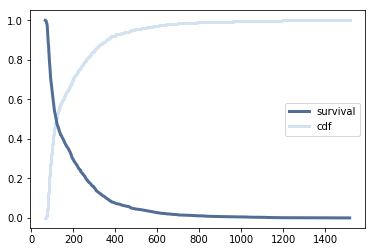

In [5]:
thinkplot.Plot(sf)
thinkplot.Cdf(cdf_nat, alpha=0.2)
thinkplot.Config(loc='center right')

## Função de perigo

A partir da curva de sobrevivência podemos derivar a função de perigo;

\begin{equation}
    \lambda(t) = \frac{S(t)-S(t+1)}{S(t)}
\end{equation}

$PMF(t) = S(t)-S(t+1)$



Função de perigo modela quais períodos têm as maiores ou menores chances de um evento;

In [6]:
hf = sf.MakeHazardFunction(label='hazard')
hf[1157]

0.24999999999996197

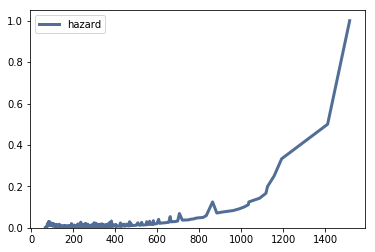

In [7]:
thinkplot.Plot(hf)
thinkplot.Config(ylim=[0, 1.05], loc='upper left')

## Inferir curvas de sobrevivência

## Estimativa de Kaplan-Meier

A ideia geral é que podemos usar os dados para estimar a **função hazard**, depois **converter** a função hazard numa **curva de sobrevivência**.

\begin{equation}
    \hat{R}(t) = \frac{número\ de\ itens\ em\ operação\ até\ o\ tempo\ t}{número\ total\ de\ itens\ no\ teste}
\end{equation}

\begin{equation}
    \hat{R}_{j}^{+} = \left\{\begin{matrix}
    \frac{n_j - d_j}{n_j} & se\ j = 1,\\ 
    \frac{n_j - d_j}{n_j}\hat{R}_{j-1}^{+} & se\ j = 2, ..., k 
    \end{matrix}\right.
\end{equation}

Considera tantos intervalos de tempo quantos forem o número de tempos distintos de falha.

$d_j$: número falhas no tempo $t_i$;

$n_j$: número de itens em risco no tempo $t_j$

In [8]:
from collections import Counter

def EstimateMarriageSurvival(dados, limiar, label=""):
    
    complete = dados[dados >= limiar].dropna()
    ongoing = dados[dados < limiar]

    hf = survival.EstimateHazardFunction(complete, ongoing, label=label)
    sf = hf.MakeSurvival()

    return hf, sf

hf1, sf1 = EstimateMarriageSurvival(dados=dados_nat, limiar=500)

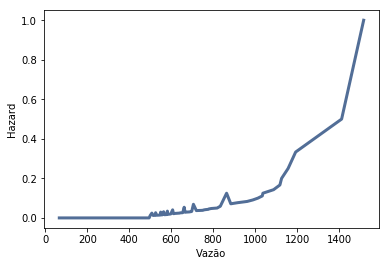

In [9]:
thinkplot.Plot(hf1)
thinkplot.Config(xlabel='Vazão',
                 ylabel='Hazard')

## Estimando a curva de sobrevivência

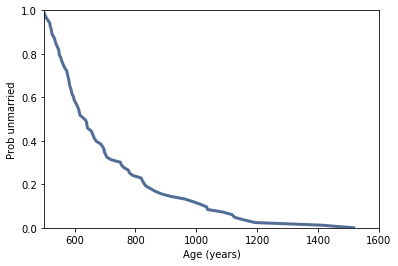

In [10]:
sf = hf1.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 ylim=[0, 1],
                xlim=[500, 1600])

## Intervalos de confiança

Importante quantificar a incerteza da estimativa.

- Erro de medição;
- Erro de amostragem; 
- Erro de modelagem.

Podemos quantificar o erro de amostragem por reamostragens;



In [11]:
def ResampleSurvival(dados, limiar, iters=101):
    """Resamples respondents and estimates the survival function.

    resp: DataFrame of respondents
    iters: number of resamples
    """ 
    _, sf = EstimateMarriageSurvival(dados, limiar)
    thinkplot.Plot(sf)

    low, high = dados.min(), dados.max()
    ts = np.arange(low, high, 1)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(pd.DataFrame(dados), column='MANSO')
        _, sf = EstimateMarriageSurvival(sample['MANSO'], limiar)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='gray', label='90% CI')

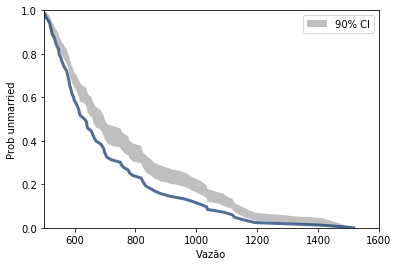

In [12]:
ResampleSurvival(dados_nat, 500)
thinkplot.Config(xlabel='Vazão',
                 ylabel='Prob unmarried',
                 xlim=[500, 1600],
                 ylim=[0, 1],
                 loc='upper right')

O intervalo de confiança leva em conta os pesos de amostragem;

Os pesos de amostragem têm um efeito substancial na estimativa;

## Efeitos de coorte

A curva estimada são baseadas em diferentes grupos de respondentes;

Podemos investigar esse efeito agrupando os entrevistados;



/home/clebsonpy/Documentos/Projetos/ThinkStats2/code/Estatística/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')


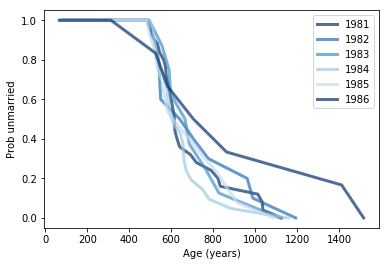

In [13]:
dados_year = dados_nat.groupby(pd.Grouper(freq='AS-AUG'))


for dados in dados_year:
    hf1, sf1 = EstimateMarriageSurvival(dados=dados[1], limiar=500, label = "%s" % dados[0].year)
    sf = hf1.MakeSurvival(label = "%s" % dados[0].year)
    thinkplot.Plot(sf)
    thinkplot.Config(xlabel='Age (years)',
                     ylabel='Prob unmarried',
                     ylim = [-0.05, 1.05])

## Extrapolação

## Vida útil restante esperada